# Investigating Fandango Movie Ratings

## Introduction
This project is the conclusion of the first course of Statistics in Dataquest. It analyses Fandango, an an online movie ratings aggregator.

## Background
In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest. This site displays a 5-star rating system, where the minimum rating is 0 stars and the maximum is 5 stars.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:
- The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis. For this, we will compare the system's characteristics previous and after the analysis. Fortunately, we have ready-made data for both these periods of time:

- Walt Hickey made the data he analyzed publicly [available on GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). We'll use the data he collected to analyze the characteristics of Fandango's rating system previous to his analysis.
- One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly [available on GitHub](https://github.com/mircealex/Movie_ratings_2016_17) and we'll use it to analyze the rating system's characteristics after Hickey's analysis.

Let's start by reading the datasets and performing some initial work on the tables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
%matplotlib inline

pd.options.display.max_columns = 100  # Avoid having displayed truncated output

In [2]:
previous = pd.read_csv('fandango_score_comparison.csv')
after = pd.read_csv('movie_ratings_16_17.csv')
previous.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,1.10,2.35,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,1.45,1.70,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [3]:
after.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


We can reduce the dataset to keep only the most important columns for this analysis.

In [4]:
fandango_previous = previous[[
        'FILM',
        'Fandango_Stars',
        'Fandango_Ratingvalue',
        'Fandango_votes',
        'Fandango_Difference'
        ]].copy()

fandango_after = after[[
        'movie',
        'year',
        'fandango'
        ]].copy()

fandango_previous.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [5]:
fandango_after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


## Analysing sampling and population

We are focused on the confirmation (or not) of the hypothesis, while comparing the ratings after Hickey's analysis, so we need to focus on the analysed populations, to ensure they match to be compared. Both datasets are samples of the population, so their selecting criteria should be similar.

We are initially focusing on movie ratings in Fandango from any year available. To focus on Hickey's article, we should analyse two samplings: before and after his analysis, in order to compare them. The data we're working with was sampled at the moments we want: one sample was taken previous to the analysis, and the other after the analysis. 

In order to describe and conclude about a population, the sample should be representative, otherwise, everything could be invalid and biased by a big sampling error, which of course is undesired.

By checking the _readme_ files on github sites linked above, we can see both sampling criteria. In Hickey's case, we can extract the following:

- Movies must have 30+ fan ratings in Fandango (up to Aug 24th 2015)
- Movie must have had tickets on sale during 2015

Here we can see that this sampling is not random if we consider the population as 'any movie without taking in account it's release year'. It is currently excluding movies with up to 29 fan ratings or movies that were not offered in 2015.

The other sample had other conditions:

- Movies released in 2016+
- Movies with a _considerable_ number of votes and reviews

Here we can also see that this sampling is not random as well, and does not represent our desired population as described before.

At this point, we have at least two alternatives: either we collect new data, either we change the goal of our analysis by placing some limitations on it. So, let's take this second choice and move on.

## Recalculating

We can move our analysis goal to find if there are differences in popular movies ratings in 2015 compared to 2016; so are new populations are:
- All Fandango's ratings for popular movies released in 2015.
- All Fandango's ratings for popular movies released in 2016.

We'll use Hickey's benchmark of 30+ fan ratings to consider a movie as _popular_, so we can check if all the movies meet this.

In [6]:
fandango_previous[fandango_previous['Fandango_votes'] < 30]

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference


__fandango\_after__ does not include ratings; if we were working on an SQL environment, we could easily check the movies that are not in both datasets (outer join) to check their votes manually, but we can consider sampling a random set of movies to verify in the website the raiting. We will include random state with 7 (a number I like), in order to keep the _randomness_ consistent for any repeating instance of this code.

In [7]:
fandango_after.sample(10, random_state = 7)

,movie,year,fandango
138,Rings,2017,3.0
65,Hacksaw Ridge,2016,4.5
95,Lights Out,2016,4.0
22,Ben-Hur,2016,4.0
63,Gods of Egypt,2016,3.5
46,Elle,2016,3.5
97,Live by Night,2016,3.5
11,Approaching the Unknown,2016,3.5
2,A Cure for Wellness,2016,3.0
82,Jackie,2016,3.5


By May 2nd 2020, we can see these number ratings in Rotten Tomatoes (which shows total ratings easier):

|          Movie          | Rotten Tomatoes Critics |
|:-----------------------:|:-----------------------:|
|          Rings          |           112           |
|      Hacksaw Ridge      |           269           |
|        Lights Out       |           175           |
|         Ben-Hur         |           188           |
|      Gods of Egypt      |           189           |
|           Elle          |           235           |
|      Live by Night      |           231           |
| Approaching the Unknown |            21           |
|   A Cure for Wellness   |           205           |
|          Jackie         |           342           |

We can see that 9/10 movies have 100+ reviews, so we can consider this dataset as representative, while keeping some suspicion.

We also need to split the datasets by release year (2015 or 2016 in separated datasets). The release year is included in film name, so we can create a column in the dataset with the year.

In [8]:
fandango_previous['Year'] = fandango_previous['FILM'].str[-5:-1]
fandango_previous['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [9]:
fandango_2015 = fandango_previous[fandango_previous['Year'] == '2015'].copy()

Now we can move forward to the other dataset, which has this column already.

In [10]:
fandango_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [11]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()

## Comparing 2015 and 2016 distributions

We can now start analyzing the two samples we isolated before. Our goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and 2016. Let's start simple with making a high-level comparison between the shapes of the distributions of movie ratings for both samples.

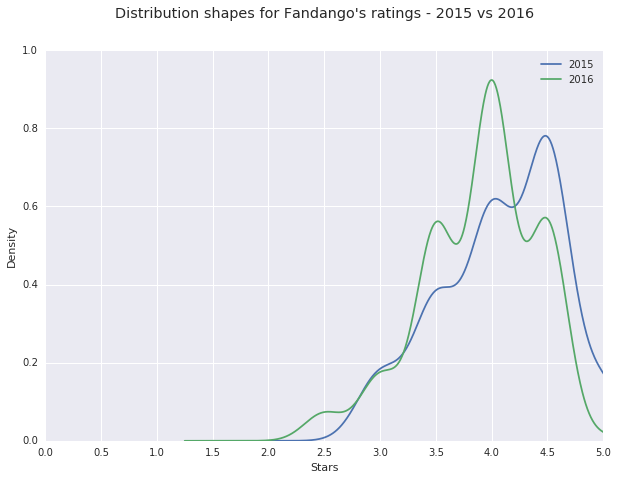

In [12]:
fandango_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (10,7))
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)

plt.style.use('ggplot')
plt.title("Distribution shapes for Fandango's ratings - 2015 vs 2016", y = 1.07)
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0,5.1,.5))
plt.show()

2015 and 2016 shapes seem both left skewed, but with a different center. For 2015 is around 4.5, while in 2016 the center is in 4.0.
It is to notice that both curves have important values above 2.0, which means that Fandango (a ticket selling system as well) does not include _bad movies_, which is (at least) to suspect. This comparison sugest that the average rating shifted down one star half.

Let's further investigate frequency tables to compare them.

In [13]:
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index()*100

3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [14]:
fandango_2016['fandango'].value_counts(normalize = True).sort_index()*100

2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

We can see some important changes:
- The percentage of movies with 5 stars is significantly lower (about 7% to less than 1%).
- Some values below 3.0 stars appeared in 2016 movies.
- 4.5 stars percentage lost about 50% of its total, which moved to 4.0 group, that increased about 50% as well.

## Metrics
We can also analyse some metrics, in order to see the direction of the change between 2015 and 2016. Let's check basic statistics, such as mean, median and mode.

In [15]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
median_2015 = fandango_2015['Fandango_Stars'].median()
mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]
mean_2016 = fandango_2016['fandango'].mean()
median_2016 = fandango_2016['fandango'].median()
mode_2016 = fandango_2016['fandango'].mode()[0]

print('2015 statistics')
print('Mean: ' + str(round(mean_2015,2)))
print('Median: ' + str(round(median_2015,2)))
print('Mode: ' + str(round(mode_2015,2)))
print('\n')
print('2016 statistics')
print('Mean: ' + str(round(mean_2016,2)))
print('Median: ' + str(round(median_2016,2)))
print('Mode: ' + str(round(mode_2016,2)))

2015 statistics
Mean: 4.09
Median: 4.0
Mode: 4.5


2016 statistics
Mean: 3.89
Median: 4.0
Mode: 4.0


We can see a change in the mean, descending 0.2 stars. Rounding both values to the closest integer, both fall into 4.0 star, so it should not be noticed. The median remain the same, but the mode went from 4.5 to 4.0. Remember that the mode is equal to the mean in normal distributions, but a better indicator of the _average_ behavior in non-normal distributions.

We can visualize the differences with a grouped bar plot.

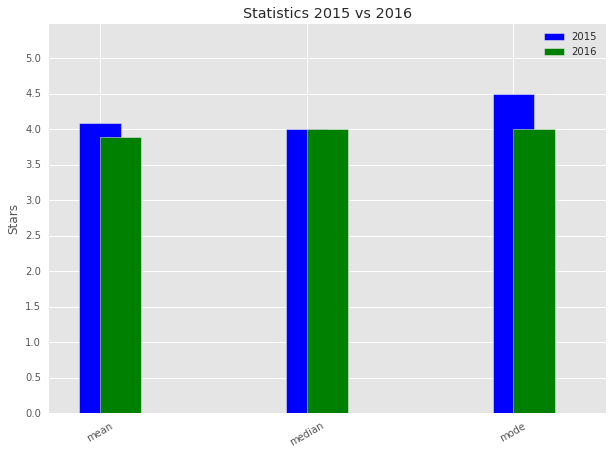

In [16]:
statistics = pd.DataFrame()
statistics['2015'] = [mean_2015, median_2015, mode_2015]
statistics['2016'] = [mean_2016, median_2016, mode_2016]
statistics.index = ['mean', 'median', 'mode']

plt.style.use('ggplot')
statistics['2015'].plot.bar(color = 'blue', align = 'center', label = '2015', width = .2)
statistics['2016'].plot.bar(color = 'green', align = 'edge', label = '2016', width = .2, figsize = (10, 7), rot = 30)

plt.title('Statistics 2015 vs 2016')
plt.ylim(0, 5.5)
plt.yticks(arange(0, 5.1, .5))
plt.ylabel('Stars')
plt.legend()
plt.show()

## Conclusion

We can conclude that the direction of the change is the one described earlier: popular movies released in 2016 were rated lower the ones from 2015. This is not extendable to any movie, because of the sampling problems described before, but it is a good sign of tendency at least for the 2015/2016 season. It is not clear if its related to a change in movies or in Fandango's algorythm after Hickey's article.